In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [2]:
!unzip -qq /kaggle/input/dogs-vs-cats/test1.zip
!unzip -qq /kaggle/input/dogs-vs-cats/train.zip

In [3]:
import random
import os
import numpy as np
import pandas as pd 
import seaborn as sns
from PIL import Image, ImageFilter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

In [4]:
# Function to read and flatten images
def read_process_and_flatten_image(file_path, target_size=(350, 350), blur_radius=2):
    with Image.open(file_path) as img:
        # Resize image
        img = img.resize(target_size, Image.ANTIALIAS)
        # Apply blurring
        img = img.filter(ImageFilter.GaussianBlur(blur_radius))
        # Normalize pixel values
        img_array = np.array(img) / 255.0
        # Flatten image
        img_array_flattened = img_array.flatten()
    return img_array_flattened

# Define the directories containing the images
train_dir = "/kaggle/working/train/"

# Initialize lists to store file paths, pixel values, and labels
file_paths = []
pixels = []
labels = []
# Iterate over the train directory to collect file paths, pixel values, and labels
for file_name in os.listdir(train_dir)[:1100]:  # Selecting 1000 images for training
    file_path = os.path.join(train_dir, file_name)
    file_paths.append(file_path)
    image_pixels = read_process_and_flatten_image(file_path)
    pixels.append(image_pixels)
    labels.append(file_name.split('.')[0])  # Assuming label is before the first '.'

# Apply PCA to reduce dimensionality of the pixel values
pca = PCA(n_components=100)  # Adjust the number of components as needed
pixels_pca = pca.fit_transform(pixels)

# Create a DataFrame from the collected data
data = pd.DataFrame({'file_path': file_paths, 'pixels_pca': pixels_pca.tolist(), 'label': labels})

# Shuffle the DataFrame to randomize the order of the data
data = data.sample(frac=1).reset_index(drop=True)

/tmp/ipykernel_18/1548358886.py:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize(target_size, Image.ANTIALIAS)


In [5]:
data['label'].value_counts()

label
dog    555
cat    545
Name: count, dtype: int64

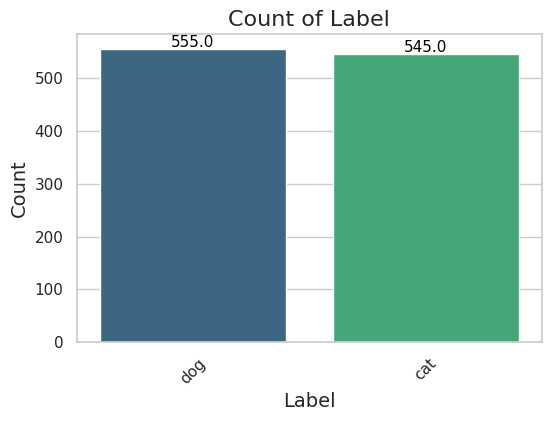

In [6]:
sns.set(style="whitegrid")  # Set the style
plt.figure(figsize=(6, 4))  # Set the figure size

custom_cmap = "viridis"  # You can choose any colormap you prefer

ax = sns.countplot(x='label', data=data, order=data['label'].value_counts().index, palette=custom_cmap)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of Label', fontsize=16)

plt.xticks(rotation=45)

# Show plot
plt.show()

In [7]:
data.iloc[0]

file_path                     /kaggle/working/train/cat.990.jpg
pixels_pca    [-109.93915623518657, 35.18356227227909, 35.39...
label                                                       cat
Name: 0, dtype: object

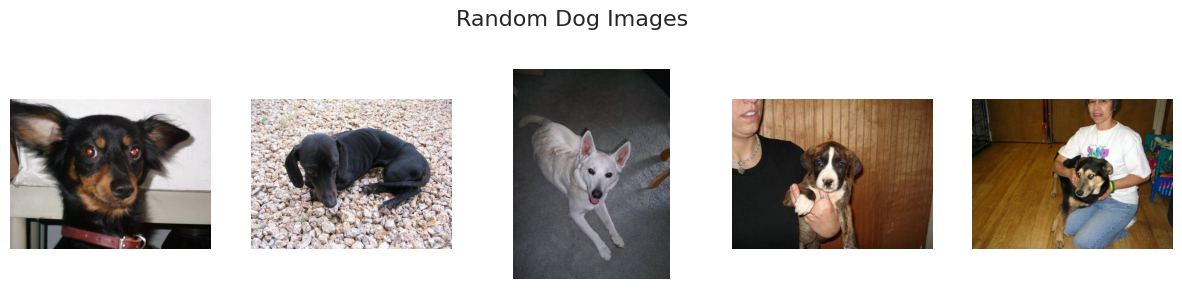

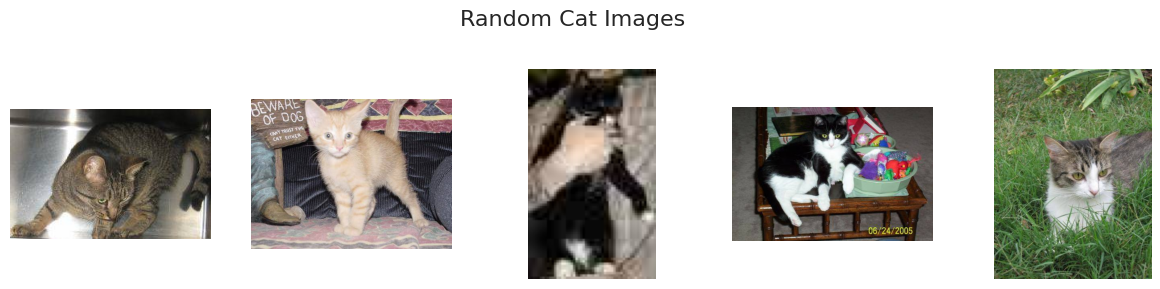

In [8]:
# Dog Image
plt.figure(figsize=(15, 6))
plt.suptitle('Random Dog Images', fontsize=16)
for i, img_file in enumerate(random.sample(list(data[data['label'] == 'dog']['file_path']), 5), 1):
    plt.subplot(2, 5, i)
    img = mpimg.imread(img_file)
    plt.imshow(img)
    plt.axis('off')


## Cat Image    
plt.figure(figsize=(15, 6))
plt.suptitle('Random Cat Images', fontsize=16)
for i, img_file in enumerate(random.sample(list(data[data['label'] == 'cat']['file_path']), 5), 1):
    img_path = os.path.join("/kaggle/working/train", img_file)
    plt.subplot(2, 5, i)
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(data['pixels_pca'].tolist(), data['label'], test_size=0.1, random_state=42)

In [10]:
print('Training data ', len(X_train))
print('Testing data ', len(X_test))

Training data  990
Testing data  110


In [11]:
# Standardize the pixel values
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
pd.DataFrame(X_train_scaled)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,1.048960,-1.375591,-0.128122,0.799742,-0.890318,1.827616,-0.216541,-0.691842,-1.359286,2.062678,...,0.423711,0.404518,0.578709,0.381394,-0.962725,-0.948152,1.436632,0.668711,-0.423812,-0.777249
1,0.445559,0.509947,0.718913,-0.521141,-0.109643,0.397289,-0.295704,-0.995416,0.000913,-0.202779,...,0.161225,-0.315663,0.047253,0.109009,0.347562,0.171414,-0.104909,-0.089007,0.189572,-1.319405
2,-0.087492,-0.238985,-0.680366,0.826251,0.264646,0.640699,0.812757,-1.646326,0.617617,-1.038947,...,0.551062,-0.022952,0.604835,-1.130799,0.106598,0.141775,0.923283,-0.897079,0.948689,0.689043
3,1.630831,1.524653,1.671435,-0.906958,-0.898803,0.909427,0.490531,1.324186,0.835060,-1.306997,...,0.431526,-1.456655,0.278782,2.021248,1.285284,-2.185813,0.267289,-0.661233,0.855934,0.641414
4,0.853821,0.925900,-1.489806,0.288511,1.900907,4.266691,2.401255,0.945987,1.152354,0.122433,...,-1.590190,0.417872,1.098834,-1.547427,-0.529560,-0.827135,0.928907,1.628266,0.254240,-0.360146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985,-0.554013,0.755977,0.028319,-0.003918,0.237527,-0.334980,0.581428,-0.648973,0.057109,-0.458870,...,-0.370382,-0.459640,0.120576,-2.268039,1.224059,0.983051,-0.171268,-0.876911,0.290873,-0.826416
986,-0.225721,1.132936,-0.011052,0.565665,-0.245372,0.055069,0.537895,-0.694988,-0.523498,0.875073,...,0.646070,0.192408,0.657276,-0.152643,0.533226,-0.043612,0.292478,-0.480291,0.110444,0.054661
987,0.262990,-1.207844,0.168408,0.618178,0.141016,0.395921,1.788169,0.309562,-0.282297,-0.172624,...,-3.315358,-1.965636,0.877619,-0.440317,0.090691,-1.704308,0.143837,-1.572330,0.337001,-0.344569
988,-1.799827,0.342257,0.408009,0.882836,0.524420,-0.401253,0.898581,1.984419,2.577888,0.865995,...,1.362937,1.853838,-0.141815,1.780794,-0.299668,-1.702386,0.834003,-0.731509,2.288567,0.549866


In [13]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
log_reg_pred = log_reg.predict(X_test_scaled)
log_reg_accuracy = accuracy_score(y_test, log_reg_pred)
print("Logistic Regression Accuracy:", log_reg_accuracy)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, log_reg_pred))

Logistic Regression Accuracy: 0.6
Logistic Regression Classification Report:
              precision    recall  f1-score   support

         cat       0.61      0.61      0.61        56
         dog       0.59      0.59      0.59        54

    accuracy                           0.60       110
   macro avg       0.60      0.60      0.60       110
weighted avg       0.60      0.60      0.60       110



In [14]:
svm_clf = SVC()
svm_clf.fit(X_train_scaled, y_train)
svm_pred = svm_clf.predict(X_test_scaled)
svm_accuracy = accuracy_score(y_test, svm_pred)
print("SVM Accuracy:", svm_accuracy)
print("SVM Classification Report:")
print(classification_report(y_test, svm_pred))

SVM Accuracy: 0.6363636363636364
SVM Classification Report:
              precision    recall  f1-score   support

         cat       0.64      0.66      0.65        56
         dog       0.63      0.61      0.62        54

    accuracy                           0.64       110
   macro avg       0.64      0.64      0.64       110
weighted avg       0.64      0.64      0.64       110



In [15]:
# Decision Tree Classifier
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train_scaled, y_train)
tree_pred = tree_clf.predict(X_test_scaled)
tree_accuracy = accuracy_score(y_test, tree_pred)
print("\nDecision Tree Accuracy:", tree_accuracy)
print("Decision Tree Classification Report:")
print(classification_report(y_test, tree_pred))


Decision Tree Accuracy: 0.6181818181818182
Decision Tree Classification Report:
              precision    recall  f1-score   support

         cat       0.61      0.71      0.66        56
         dog       0.64      0.52      0.57        54

    accuracy                           0.62       110
   macro avg       0.62      0.62      0.61       110
weighted avg       0.62      0.62      0.61       110



In [16]:
# Random Forest Classifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_scaled, y_train)
rf_pred = rf_clf.predict(X_test_scaled)
rf_accuracy = accuracy_score(y_test, rf_pred)
print("\nRandom Forest Accuracy:", rf_accuracy)
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))


Random Forest Accuracy: 0.6
Random Forest Classification Report:
              precision    recall  f1-score   support

         cat       0.60      0.62      0.61        56
         dog       0.60      0.57      0.58        54

    accuracy                           0.60       110
   macro avg       0.60      0.60      0.60       110
weighted avg       0.60      0.60      0.60       110



In [17]:
# Hyperparameter tuning for Logistic Regression
param_grid_log_reg = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search_log_reg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_log_reg, cv=5, scoring='accuracy')
grid_search_log_reg.fit(X_train_scaled, y_train)

print("Best parameters for Logistic Regression:", grid_search_log_reg.best_params_)
print("Best cross-validation score for Logistic Regression:", grid_search_log_reg.best_score_)

Best parameters for Logistic Regression: {'C': 0.001}
Best cross-validation score for Logistic Regression: 0.5454545454545455


In [18]:
# Define the parameter grid for Decision Tree Classifier
param_grid_decision_tree = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# Perform GridSearchCV for Decision Tree Classifier
grid_search_decision_tree = GridSearchCV(
    DecisionTreeClassifier(), 
    param_grid_decision_tree, 
    cv=5, 
    scoring='accuracy'
)


grid_search_decision_tree.fit(X_train_scaled, y_train)

# Print the best parameters and best cross-validation score
print("Best parameters for Decision Tree Classifier:")
print(grid_search_decision_tree.best_params_)
print("Best cross-validation score for Decision Tree Classifier:")
print(grid_search_decision_tree.best_score_)

/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/tree/_classes.py:269: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'`.
  warnings.warn(
/opt/conda/lib/pytho

Best parameters for Decision Tree Classifier:
{'max_depth': 40, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5}
Best cross-validation score for Decision Tree Classifier:
0.5595959595959596
